<center><h1> ComplEX - Variable Negative Training Samples </h1></center>

# Open Graph Benchmark Library (OGBL) - BioKG

<b>Graph</b> : The ogbl-biokg dataset is a Knowledge Graph (KG), which we created using data from a large number of biomedical data repositories. It contains 5 types of entities: diseases (10,687 nodes), proteins (17,499), drugs (10,533 nodes), side effects (9,969 nodes), and protein functions (45,085 nodes). There are 51 types of directed relations connecting two types of entities, including 39 kinds of drug-drug interactions, 8 kinds of protein-protein interaction, as well as drug-protein, drug-side effect, drug-protein, function-function relations. All relations are modeled as directed edges, among which the relations connecting the same entity types (e.g., protein-protein, drug-drug, function-function) are always symmetric, i.e., the edges are bi-directional.

This dataset is relevant to both biomedical and fundamental ML research. On the biomedical side, the dataset allows us to get better insights into human biology and generate predictions that can guide downstream biomedical research. On the fundamental ML side, the dataset presents challenges in handling a noisy, incomplete KG with possible contradictory observations. This is because the ogbl-biokg dataset involves heterogeneous interactions that span from the molecular scale (e.g., protein-protein interactions within a cell) to whole populations (e.g., reports of unwanted side effects experienced by patients in a particular country). Further, triplets in the KG come from sources with a variety of confidence levels, including experimental readouts, human-curated annotations, and automatically extracted metadata.

<b>Prediction task</b>: The task is to predict new triplets given the training triplets. The evaluation protocol is exactly the same as ogbl-wikikg2, except that here we only consider ranking against entities of the same type. For instance, when corrupting head entities of the protein type, we only consider negative protein entities.

<b>Dataset splitting</b>: For this dataset, we adopt a random split. While splitting the triplets according to time is an attractive alternative, we note that it is incredibly challenging to obtain accurate information as to when individual experiments and observations underlying the triplets were made. We strive to provide additional dataset splits in future versions of the OGB.



# Installing libraries (OGB & TorchKGE)

The OGB (Open Graph Benchmark) library is used in this notebook to retrieve the knowledge graph and to evaluate our model.<br/>
The TorchKGE library is used to create our model.

In [1]:
# Installing OBG to download dataset
!pip install ogb

# Getting TorchKGE library
!git clone https://github.com/torchkge-team/torchkge.git
!mv /content/torchkge /content/torchkge_repo
!mv /content/torchkge_repo/torchkge /content/torchkge
!pip install -r /content/torchkge_repo/requirements_dev.txt

     |████████████████████████████████| 71kB 6.4MB/s 
  Created wheel for littleutils: filename=littleutils-0.2.2-cp37-none-any.whl size=7051 sha256=430f925e99d74d570cf5f3a347ca344c03ae8fd6dbe43b8d5dfa9be6287c425b
  Stored in directory: /root/.cache/pip/wheels/53/16/9f/ac67d15c40243754fd73f620e1b9b6dedc20492ecc19a2bae1
Successfully built littleutils
Cloning into 'torchkge'...
remote: Enumerating objects: 3410, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 3410 (delta 54), reused 82 (delta 52), pack-reused 3321
Receiving objects: 100% (3410/3410), 794.66 KiB | 9.35 MiB/s, done.
Resolving deltas: 100% (2256/2256), done.
     |████████████████████████████████| 2.9MB 14.6MB/s 
     |████████████████████████████████| 9.2MB 42.1MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
     |████████████████████████████████| 81kB 10.3MB/s 
     |████████████████████████████████| 92kB 9.5MB/s 
     |████████████████████████

# Imports

In [2]:
# General Purpose imports
import os
import sys
import json
import time
import tqdm
from copy import copy

# Math / Data structures imports
import math
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

# PyTorch imports
import torch                                                # PyTorch
from torch import cuda                                      # CUDA device
from torch.optim import Adam                                # Adam optimizer
from torch.utils.data import DataLoader

# OGB Improts
from ogb.linkproppred import Evaluator                      # Evaluates model
from ogb.linkproppred.dataset import LinkPropPredDataset    # Loads KG 

# TorchKGE imports
import torchkge
from torchkge.utils.data import DataLoader as KGEDataLoader               # Loads batches
from torchkge.utils.losses import MarginLoss                # Loss function
from torchkge.models.bilinear import ComplExModel           # KGE Model
from torchkge.data_structures import KnowledgeGraph         # KG object
from torchkge.sampling import BernoulliNegativeSampler      # Corrupts triplets

# Accessing data

In [3]:
dataset = LinkPropPredDataset(name = 'ogbl-biokg')

Downloaded 0.90 GB: 100%|██████████| 920/920 [09:57<00:00,  1.54it/s]


Extracting dataset/biokg.zip
Loading necessary files...
This might take a while.


100%|██████████| 1/1 [00:00<00:00, 1664.41it/s]

Processing graphs...
Saving...


In [4]:
# Getting the dataset train-val-test split
split_set = dataset.get_edge_split()
train_set, valid_set, test_set = split_set["train"], split_set["valid"], split_set["test"]

#Re-indexing the dataset from (type, index) to (index)
# Getting the dataset train-val-test split
split_set = dataset.get_edge_split()
train_set, valid_set, test_set = split_set["train"], split_set["valid"], split_set["test"]


def type_and_id_2_new_id(typ, id):
  base = 0

  if 'dis' in typ:
    base += 0
  elif 'prot' in typ:
    base = 10_687
  elif 'drug' in typ:
    base = 10_687 + 17_499
  elif 'effe' in typ:
    base = 10_687 + 17_499 + 10_533
  elif 'fun' in typ:
    base = 10_687 + 17_499 + 10_533 + 9_969

  return base + id

def trainset_to_newset(train_set):
  tmp_set = []

  for ht, h, r, tt, t in zip(train_set['head_type'], train_set['head'], train_set['relation'], train_set['tail_type'], train_set['tail']):
    head_id = type_and_id_2_new_id(ht, h)
    tail_id = type_and_id_2_new_id(tt, t)
  
    tmp_set.append([head_id, r, tail_id])
  
  return pd.DataFrame(np.array(tmp_set), columns=['head', 'relation', 'tail'])

def valset_to_newset(val_set):
  tmp_set = []

  for ht, h, nhs, r, tt, t, nts in zip(val_set['head_type'], val_set['head'], val_set['head_neg'], val_set['relation'], val_set['tail_type'], val_set['tail'], val_set['tail_neg']):
    h_id = type_and_id_2_new_id(ht, h)
    t_id = type_and_id_2_new_id(tt, t)

    nh_ids, nt_ids = [], []
    for nh, nt in zip(nhs, nts):
      nh_id = type_and_id_2_new_id(ht, nh)
      nt_id = type_and_id_2_new_id(tt, nt)

      nh_ids.append(nh_id)
      nt_ids.append(nt_id)

    tmp_set.append([h_id, nh_ids, r, t_id, nt_ids])
  
  return pd.DataFrame(np.array(tmp_set), columns=['head', 'head_neg', 'relation', 'tail', 'tail_neg'])
  
train_set = trainset_to_newset(train_set)
valid_set = valset_to_newset(valid_set)
test_set = valset_to_newset(test_set)

# Getting the sets of entities and relations (IDs)
train_set_df = pd.DataFrame(train_set)
entities_set = set(list(set(train_set_df['head'])) + list(set(train_set_df['tail'])))
relations_set = set(train_set['relation'])

# Showing infos
print(train_set_df)
print("Number of distinct entities: ", len(entities_set))
print("Number of distinct relations: ", len(relations_set))

df_train = pd.DataFrame(train_set)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


          head  relation   tail
0         1718         0  13894
1         4903         0  24349
2         5480         0  26686
3         3148         0  17934
4        10300         0  26889
...        ...       ...    ...
4762673  24553        50  22370
4762674  21512        50  11344
4762675  23345        50  22686
4762676  22715        50  13169
4762677  12783        50  12780

[4762678 rows x 3 columns]
Number of distinct entities:  93773
Number of distinct relations:  51


In [5]:
# Getting the sets of entities and relations (IDs)
entities_set = set(list(set(train_set_df['head'])) + list(set(train_set_df['tail'])))
relations_set = set(train_set_df['relation'])

# Showing infos
print(train_set_df)
print("Number of distinct entities: ", len(entities_set))
print("Number of distinct relations: ", len(relations_set))

          head  relation   tail
0         1718         0  13894
1         4903         0  24349
2         5480         0  26686
3         3148         0  17934
4        10300         0  26889
...        ...       ...    ...
4762673  24553        50  22370
4762674  21512        50  11344
4762675  23345        50  22686
4762676  22715        50  13169
4762677  12783        50  12780

[4762678 rows x 3 columns]
Number of distinct entities:  93773
Number of distinct relations:  51


In [6]:
# Defining our knowledge graph
print("Creating TorchKGE knowledge graph object. This might take a while...")
bio_knowledge_graph = KnowledgeGraph(df=pd.DataFrame(np.array(train_set_df[['head', 'tail', 'relation']]), columns=['from', 'to', 'rel']))
print("Knowledge Graph created successfully!")

Creating TorchKGE knowledge graph object. This might take a while...
Knowledge Graph created successfully!


# Defining the evaluation function

We have 162886 actual facts, we want to see where each actual fact gets ranked when compared with 500 corrupted facts.<br/>
The Mean-Reciprocal Ranking (MRR) is computed as $MRR = \frac{1}{N}\sum_i^N\frac{1}{r_i}$ where $r_i$ is the rank of the i-th correct fact (from 1 to 501st). Best possible model always rank correct facts first (i.e. $r_i=1, \ \ \forall i)$ and obtains an MRR of 1.

In [7]:
def evaluate(eval_set, model):
  # OGB Evaluator
  evaluator = Evaluator('ogbl-biokg')

  # Loading test / evaluation data as (h,t,r) and (h',t',r) triplets
  heads, tails, relations = eval_set['head'], eval_set['tail'], eval_set['relation']
  heads_n, tails_n = eval_set['head_neg'], eval_set['tail_neg']

  # Conversion to PyTorch tensors and in cuda memory
  # heads, tails, relations = torch.tensor(heads).cuda(), torch.tensor(tails).cuda(), torch.tensor(relations).cuda()
  # heads_n, tails_n = torch.tensor(heads_n).cuda(), torch.tensor(tails_n).cuda()

  # print(heads.shape, tails.shape, relations.shape, heads_n.shape, tails_n.shape)

  # Getting predictions on test / evaluation set
  # model(heads, tails, heads_n, tails_n, relations) # Is this allowed ???
  counter = 0
  y_pred_pos, y_pred_neg = [], []
  for h, t, r, hs_n, ts_n in zip(heads, tails, relations, heads_n, tails_n):
    h = torch.tensor(500 * [h]).cuda()
    t = torch.tensor(500 * [t]).cuda()
    r = torch.tensor(500 * [r]).cuda()
    h_n = torch.tensor(hs_n).cuda().view(-1)
    t_n = torch.tensor(ts_n).cuda().view(-1)
    
    with torch.no_grad():
      y_pos, y_neg = model(h, t, h_n, t_n, r)
      y_pred_pos.append(y_pos.cpu().numpy()[0])
      y_pred_neg.append(y_neg.cpu().numpy())
        
  # Evaluating predictions
  metrics = evaluator.eval({
      'y_pred_pos': np.array(y_pred_pos), # Predictions on the actual facts
      'y_pred_neg': np.array(y_pred_neg),    # Predictions on the corrupted facts
  })

  metrics
  return metrics 

# Learning embeddings and scoring function

The implementation provided by TorchKGE (https://github.com/torchkge-team/torchkge) seems to be the fastest open-source KGE implementation available. Documentation: https://torchkge.readthedocs.io/en/latest/

In [8]:
from google.colab import drive

# Mounting drive to store the best weights
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
def train_complex_model(k, n_ent, n_rel, lr, batch_size, n_epochs, margin, validation_frequency, n_neg=1, model_weights_path='/content/drive/MyDrive/best_model_weights.pth', model=None):
  # Plotting variables
  best_val_mrr = 0
  best_val_epoch = 0
  val_mrrs = []

  # Creation of model, optimizer and loss function
  if not model:
    model = ComplExModel(k, n_ent, n_rel)
  optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-5)
  criterion = MarginLoss(margin)

  # Sampler and DataLoader to load legit and corrupted facts 
  # sampler = BernoulliNegativeSampler(bio_knowledge_graph, n_neg=30)
  sampler = BernoulliNegativeSampler(bio_knowledge_graph, n_neg=n_neg)
  data_loader = KGEDataLoader(bio_knowledge_graph, batch_size=batch_size, use_cuda='all')

  # Moving model and loss to cuda (GPU)
  if cuda.is_available():
    print("Found CUDA device and moving model to it")
    cuda.empty_cache()
    model.cuda()
    criterion.cuda()
  else:
    print("No CUDA device found! Training might take too long")


  # Training loop
  iterator = tqdm.tqdm(range(n_epochs), unit='epoch')
  for epoch in iterator:
      running_loss = 0.0
      for i, batch in enumerate(data_loader):
          h, t, r = batch[0], batch[1], batch[2]
          
          n_h, n_t = sampler.corrupt_batch(h, t, r)
          # forward + backward + optimize
          pos, neg = model(h, t, n_h, n_t, r)
          loss = criterion(pos, neg)

          loss.backward()
          optimizer.step()
          optimizer.zero_grad()


          running_loss += loss.item()
      iterator.set_description(
          'Epoch {} | mean loss: {:.5f}'.format(
              epoch + 1,
              running_loss / len(data_loader)
            )
      )

      if epoch % validation_frequency == 0 and epoch != 0:
        metrics = evaluate(valid_set, model)
        mrr = metrics['mrr_list'].mean()
        val_mrrs.append(mrr)

        if mrr > best_val_mrr:
          best_val_mrr = mrr
          best_val_epoch = epoch
          torch.save(model, model_weights_path)
        else:
          break

  print("\nTraining finished")
  print("Best validation MRR is {} (epoch {})".format(best_val_mrr, best_val_epoch))
  # Normalizing parameters after training is done
  model.normalize_parameters()
  print("Model parameters were normalized")

  plt.plot(np.arange(len(val_mrrs)) * validation_frequency, val_mrrs, 'g-', label='val mrr')
  plt.legend()
  plt.title("Validation MRR through time")
  plt.xlabel("Epoch")
  plt.ylabel("Val MRR")
  plt.show()

  return model, best_val_mrr, metrics

  0%|          | 0/100 [00:00<?, ?epoch/s]

Found CUDA device and moving model to it


Epoch 25 | mean loss: 115.51578:  24%|██▍       | 24/100 [1:30:55<4:23:02, 207.66s/epoch]


Training finished
Best validation MRR is 0.7929752469062805 (epoch 21)
Model parameters were normalized


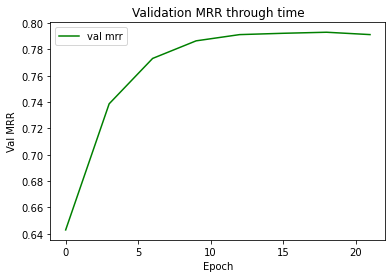

In [10]:
# Training parameters
k, n_ent, n_rel = 750, 93773, 51
lr = 0.0001
batch_size = 1000
n_epochs = 100
margin = 0.8
validation_frequency = 3
n_neg = 10

# Train a brand new model
model, mrr, metrics = train_complex_model(k, n_ent, n_rel, lr, batch_size, n_epochs, margin, validation_frequency, n_neg)

# Keep on training old model
#model, mrr = train_complex_model(k, n_ent, n_rel, lr, batch_size, n_epochs, margin, validation_frequency, n_neg, model=model)


  0%|          | 0/100 [00:00<?, ?epoch/s]

Found CUDA device and moving model to it



Epoch 1 | mean loss: 2738.33301:   0%|          | 0/100 [02:38<?, ?epoch/s]
Epoch 1 | mean loss: 2738.33301:   1%|          | 1/100 [02:38<4:21:44, 158.63s/epoch]
Epoch 2 | mean loss: 819.23040:   1%|          | 1/100 [05:17<4:21:44, 158.63s/epoch] 
Epoch 2 | mean loss: 819.23040:   2%|▏         | 2/100 [05:17<4:19:05, 158.63s/epoch]
Epoch 3 | mean loss: 386.46385:   2%|▏         | 2/100 [07:55<4:19:05, 158.63s/epoch]
Epoch 3 | mean loss: 386.46385:   3%|▎         | 3/100 [07:55<4:16:24, 158.60s/epoch]
Epoch 4 | mean loss: 256.05438:   3%|▎         | 3/100 [10:34<4:16:24, 158.60s/epoch]
Epoch 4 | mean loss: 256.05438:   4%|▍         | 4/100 [13:25<5:36:01, 210.02s/epoch]
Epoch 5 | mean loss: 189.34059:   4%|▍         | 4/100 [16:04<5:36:01, 210.02s/epoch]
Epoch 5 | mean loss: 189.34059:   5%|▌         | 5/100 [16:04<5:08:10, 194.64s/epoch]
Epoch 6 | mean loss: 149.70829:   5%|▌         | 5/100 [18:43<5:08:10, 194.64s/epoch]
Epoch 6 | mean loss: 149.70829:   6%|▌         | 6/100 [18:43


Training finished
Best validation MRR is 0.7905072569847107 (epoch 42)
Model parameters were normalized


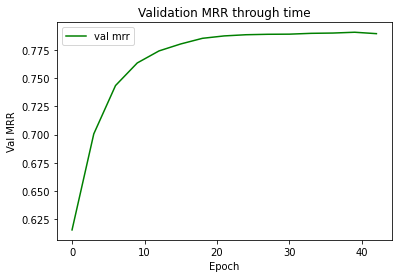

In [11]:
n_neg = 5
model, mrr, metrics = train_complex_model(k, n_ent, n_rel, lr, batch_size, n_epochs, margin, validation_frequency, n_neg)

Found CUDA device and moving model to it




  0%|          | 0/100 [00:00<?, ?epoch/s]

Epoch 1 | mean loss: 14381.91584:   0%|          | 0/100 [03:32<?, ?epoch/s]

Epoch 1 | mean loss: 14381.91584:   1%|          | 1/100 [03:32<5:50:13, 212.26s/epoch]

Epoch 2 | mean loss: 4677.81767:   1%|          | 1/100 [07:04<5:50:13, 212.26s/epoch] 

Epoch 2 | mean loss: 4677.81767:   2%|▏         | 2/100 [07:04<5:46:31, 212.16s/epoch]

Epoch 3 | mean loss: 2095.76491:   2%|▏         | 2/100 [10:36<5:46:31, 212.16s/epoch]

Epoch 3 | mean loss: 2095.76491:   3%|▎         | 3/100 [10:36<5:42:58, 212.15s/epoch]

Epoch 4 | mean loss: 1220.84534:   3%|▎         | 3/100 [14:08<5:42:58, 212.15s/epoch]

Epoch 4 | mean loss: 1220.84534:   4%|▍         | 4/100 [17:01<7:02:23, 263.99s/epoch]

Epoch 5 | mean loss: 854.12925:   4%|▍         | 4/100 [20:33<7:02:23, 263.99s/epoch] 

Epoch 5 | mean loss: 854.12925:   5%|▌         | 5/100 [20:33<6:33:24, 248.47s/epoch]

Epoch 6 | mean loss: 657.15189:   5%|▌         | 5/100 [24:05<6:33:24, 248.47s/epoc


Training finished
Best validation MRR is 0.7994519472122192 (epoch 12)
Model parameters were normalized


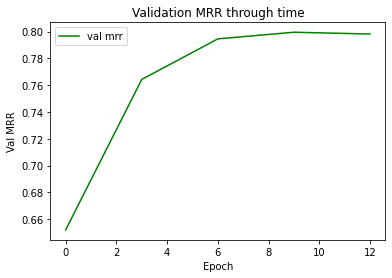

In [12]:
n_neg = 30
model, mrr, metrics = train_complex_model(k, n_ent, n_rel, lr, batch_size, n_epochs, margin, validation_frequency, n_neg)

# MRR Throughout Dataset

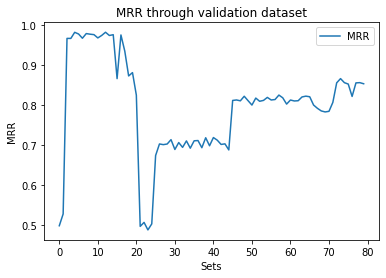

In [13]:
average_mrrs = []
for i in range(80):
  average_mrrs += [metrics['mrr_list'][i*2000:(i+1)*2000].mean()]
  
plt.plot(average_mrrs, label='MRR')
plt.legend()
plt.title("MRR through validation dataset")
plt.xlabel("Sets")
plt.ylabel("MRR")
plt.show()

# Grid search of Hyper-parameters

In [14]:
def config_to_filename(k, lr, margin):
  return "k_"+str(k)+"_lr_"+str(lr)+"_mar_"+str(margin)+".pth"

best_config = ""
best_mrr = 0

# Fixed training parameters
n_ent, n_rel = len(entities_set), len(relations_set)
batch_size = 100_000
n_epochs = 220
validation_frequency = 21

# Grid search
for k in [800, 900, 1024]:
  for lr in [0.0012]:
    for margin in [6, 12]:
      filename = config_to_filename(k, lr, margin)
      model, mrr = train_complex_model(k, n_ent, n_rel, lr, batch_size, n_epochs, margin, validation_frequency, filename)
      if mrr > best_mrr:
        best_mrr = mrr
        best_config = "k: {}\nlr: {}\nmargin: {}".format(k, lr, margin)
        print(best_config)
        print(mrr)

# Logging best result
print("Best config is\n"+best_config+"\n\nmrr: "+best_mrr)

Found CUDA device and moving model to it





  0%|          | 0/220 [00:00<?, ?epoch/s]

TypeError: ignored

# Re-loading the model

In [ ]:
!cp /content/drive/MyDrive/best_model_weights.pth /content/

In [ ]:
model = ComplExModel(k, n_ent, n_rel)
model.load_state_dict(torch.load('/content/best_model_weights.pth'))

if cuda.is_available():
  model.cuda()

# Accuracy on training set (optional)

In this example test, we go through all training facts (h, t, r) and corrupt them (h', t', r) and see how many time the scoring for the actual facts are higher, i.e. f(h, t, r) > f(h', t', r). This gives a sort of training accuracy.

In [ ]:
positive_predictions, negative_predictions = [], []
for b in data_loader:
  h, t, r = b[0], b[1], b[2]
  n_h, n_t = sampler.corrupt_batch(h, t, r)

  pos_pred, neg_pred = model(h, t, n_h, n_t, r)
  positive_predictions += [t.item() for t in pos_pred]
  negative_predictions += [t.item() for t in neg_pred]

correct, total = 0, 0
for pp, np in zip(positive_predictions, negative_predictions):
  correct = correct+1 if pp > np else correct
  total += 1

print("Actual facts win over corrupted facts {}% of the times (training set)".format(correct/total*100))

# Evaluation on the test set

In [ ]:
print("Test MRR is: ", evaluate(test_set, model))

In [ ]:
print("Valid MRR is: ", evaluate(valid_set, model))